# Introduction
In this notebook I will atempt to build a simple machine translator from English to Swedish based on Francois Chollet's article [A ten-minute introduction to sequence-to-sequence learning in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html). 

My hope is that mimicking someoneelses work with RNNs will help me grow my understanding of both RNNs and how to model them using Keras.

## Disclaimer
I will draw lots of inspiration from Chollet's [code](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py), some parts will be straight up copy pasting. 
My goal with this notebook is simply to get some more experience working with RNNs in Keras.

# Data
I will be using data from the same source as Chollet, http://www.manythings.org/anki/. I'm using the 17303 sentence long swe-eng data set, that contains english sentences and their swedish translations. The french data set used by Chollet is much larger, but he limited his training set to 10 000 sentences and used 20% of it for validation during training.

In [1]:
data_path = 'data/swe-eng/swe.txt'
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

Read all sentences.

In [2]:
input_sentences, target_sentences = [], []
for line in lines:
    try:
        input_text, target_text, *_ = line.split('\t')
    except ValueError:
        print(line)
        
    # Chollet uses tab as start of sentence and line feed as end of sentence characters.
    # The start of sentence character will be used to seed new sentences and the end
    # of sentence character will be used to terminate sentences.
    target_text = '\t' + target_text + '\n'
    input_sentences.append(input_text)
    target_sentences.append(target_text)

## Investigate sentence lengths.

In [3]:
import numpy as np

In [4]:
input_seq_lens = np.array([len(sentence) for sentence in input_sentences])
target_seq_lens = np.array([len(sentence) for sentence in target_sentences])

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [6]:
import pandas as pd

In [7]:
np.bincount(input_seq_lens).shape

(156,)

In [8]:
df = pd.DataFrame(list(zip(input_seq_lens, target_seq_lens)), columns = ['input lengths', 'target lengths'])

In [9]:
df_melt = df.melt(value_name='Sentence Length', var_name='Data Set')

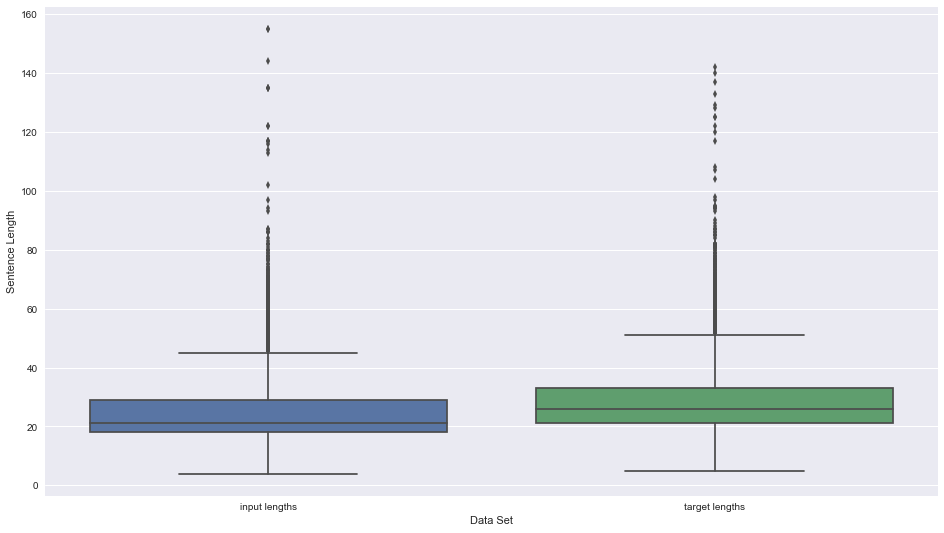

In [10]:
f, ax = plt.subplots(figsize=(16, 9))
sns.boxplot(x='Data Set', y='Sentence Length', data=df_melt)

In [11]:
df.describe()

,input lengths,target lengths
count,17304.000000,17304.000000
mean,24.809408,28.172330
std,10.960056,11.241518
min,4.000000,5.000000
25%,18.000000,21.000000
50%,21.000000,26.000000
75%,29.000000,33.000000
max,155.000000,142.000000


I will be padding all data to be of equal sentence length, to reduce the amount of padding it is convinient to not include the longest sentences.
Lets not keep any sentences longer than 50 characters.
The length doesn't have to be the same for both languages, but it is convinient.

In [27]:
max_seq_len = 50

In [13]:
 input_idx = np.where(input_seq_lens <= max_seq_len)
 target_idx = np.where(target_seq_lens <= max_seq_len)

In [29]:
print("{} input sentences with {} or fewer characters".format(len(input_idx[0]), max_seq_len))
print("{} target sentences with {} or fewer characters".format(len(target_idx[0]), max_seq_len))

16741 input sentences with 50 or fewer characters
16522 target sentences with 50 or fewer characters


In [15]:
keep_idx = np.intersect1d(input_idx, target_idx)

In [30]:
print("{} input sentence pairs with {} or fewer characters in both languages".format(len(keep_idx), max_seq_len))

16404 input sentence pairs with 50 or fewer characters in both languages


In [20]:
input_sentences = np.array(input_sentences)[keep_idx]
target_sentences = np.array(target_sentences)[keep_idx]

## Build vocabularies

In [23]:
input_characters = set()
target_characters = set()
for input_text, target_text in zip(input_sentences, target_sentences):
    for char in input_text:
        input_characters.add(char)
    for char in target_text:
        target_characters.add(char)

Sort the vocabularies.

In [24]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

input_vocab_size = len(input_characters)
target_vocab_size = len(target_characters)

In [25]:
print("Input vocab size: {}".format(input_vocab_size))
print("Target vocab size: {}".format(target_vocab_size))

Input vocab size: 75
Target vocab size: 79


In [26]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

## Build padded data

First create completely empty data.

In [31]:
encoder_input_data = np.zeros(
    (len(input_sentences), max_seq_len, input_vocab_size),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_sentences), max_seq_len, target_vocab_size),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_sentences), max_seq_len, target_vocab_size),
    dtype='float32')

In [32]:
encoder_input_data.shape

(16404, 50, 75)

In [33]:
decoder_input_data.shape

(16404, 50, 79)

In [34]:
decoder_target_data.shape

(16404, 50, 79)

Now fill in all the values that we have available, leaving the rest as padding. Encode all characters using one-hot encoding.

In [35]:
for i, (input_text, target_text) in enumerate(zip(input_sentences, target_sentences)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

## Divide data into a training and a validation set
I will use 8 000 sentances as training set and 2000 as validation set.

In [70]:
trainig_size, validation_size = 8000, 2000

In [71]:
shuffle_idx = np.random.permutation(len(input_sentences))

In [72]:
train_idx, val_idx = shuffle_idx[:trainig_size], shuffle_idx[trainig_size:trainig_size+validation_size]

In [73]:
encoder_input_train, encoder_input_val = encoder_input_data[train_idx], encoder_input_data[val_idx]

decoder_input_train, decoder_input_val = decoder_input_data[train_idx], decoder_input_data[val_idx]

decoder_target_train, decoder_target_val = decoder_target_data[train_idx], decoder_target_data[val_idx]

# Training Model

Chollet has built one model for training and the resused its layers in another model used for tranlsation.
I will copy Chollet's architecture.

In [63]:
# Config
batch_size = 64
latent_dim = 256

In [106]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# Define the encoder to have one hidden LSTM layer and output its state
encoder_inputs = Input(shape=(None, input_vocab_size))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# Only save the states of the encoder, we don't care about it's output
encoder_states = [state_h, state_c]

# Define the decoder, it will use the state of the encoder as its initial state
decoder_inputs = Input(shape=(None, target_vocab_size))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(target_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [92]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [76]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_train, decoder_input_train], decoder_target_train,
          batch_size=batch_size,
          epochs=2,
          validation_data=([encoder_input_val, decoder_input_val], decoder_target_val))

Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - 177s 22ms/step - loss: 1.4626 - val_loss: 1.3017
Epoch 2/2
8000/8000 [==============================] - 172s 22ms/step - loss: 1.1768 - val_loss: 1.0931


Challot ran his model for 100 epochs before evaluating it. This would take close to 5 hours on my laptop CPU...
I'd like to check if GRUs speed up training as they are simpler and have been shown to have similar performance as LSTM cells [Klaus Greff et al.](https://arxiv.org/pdf/1503.04069.pdf). Maybe I could use them instead.

In [146]:
from keras.layers import GRU

# Define the encoder to have one hidden GRU layer and output it's state
encoder_inputs = Input(shape=(None, input_vocab_size))
encoder = GRU(latent_dim, return_state=True)
_, state_h = encoder(encoder_inputs)

# Define the decoder, it will use the state of the encoder as its initial state
decoder_inputs = Input(shape=(None, target_vocab_size))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_gru(decoder_inputs,
                                     initial_state=state_h)
decoder_dense = Dense(target_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [147]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model2 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [148]:
# Run training
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model2.fit([encoder_input_train, decoder_input_train], decoder_target_train,
          batch_size=batch_size,
          epochs=2,
          validation_data=([encoder_input_val, decoder_input_val], decoder_target_val))

Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - 143s 18ms/step - loss: 1.4249 - val_loss: 1.1447
Epoch 2/2
8000/8000 [==============================] - 156s 20ms/step - loss: 1.0517 - val_loss: 0.9933


The time per epoch is a little bit lower, and also we reach a little bit lower validation loss. Lets bet on the GRU and allow it to train for 100 epochs.

But first, lets see what kind of translations we get after two epochs!

# Translation Model

In [149]:
encoder_model = Model(encoder_inputs, state_h)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_outputs, state_h = decoder_gru(
    decoder_inputs, initial_state=decoder_state_input_h)
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + [decoder_state_input_h],
    [decoder_outputs] + [state_h])

In [150]:
# This cell is straight up copy pasted from https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py
# With only small modifications to fit my GRU model and my global variable names

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, target_vocab_size))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h = decoder_model.predict(
            [target_seq] + [states_value])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_seq_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, target_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = h

    return decoded_sentence

In [125]:
input_sentences_val = input_sentences[val_idx]

In [151]:
for seq_index in range(5):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_val[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_sentences_val[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: I just left Tom.
Decoded sentence: Jag är inte det här inte här inte här inte här inte
-
Input sentence: Can we make it?
Decoded sentence: Det är inte det här inte här inte här inte här inte
-
Input sentence: She was right in the middle of cutting cucumbers.
Decoded sentence: Han är inte det här inte här inte här inte här inte
-
Input sentence: I've got a few more.
Decoded sentence: Jag är inte det här inte här inte här inte här inte
-
Input sentence: Did they buy it?
Decoded sentence: Han är inte det här inte här inte här inte här inte


Very similar translations for each sentence, but with some interesting details:
* The translated sentences begin with `Jag` when  the input sentence starts with `I`!
* The translated sentences are real swedish words!

Lets give the model another 98 epochs to train, for a total of 100 epochs.

In [153]:
model2.fit([encoder_input_train, decoder_input_train], decoder_target_train,
          batch_size=batch_size,
          epochs=98,
          validation_data=([encoder_input_val, decoder_input_val], decoder_target_val))

Train on 8000 samples, validate on 2000 samples
Epoch 1/98
8000/8000 [==============================] - 170s 21ms/step - loss: 0.9496 - val_loss: 0.9266
Epoch 2/98
8000/8000 [==============================] - 160s 20ms/step - loss: 0.8983 - val_loss: 0.8820
Epoch 3/98
8000/8000 [==============================] - 159s 20ms/step - loss: 0.8584 - val_loss: 0.8472
Epoch 4/98
8000/8000 [==============================] - 157s 20ms/step - loss: 0.8245 - val_loss: 0.8251
Epoch 5/98
8000/8000 [==============================] - 162s 20ms/step - loss: 0.7955 - val_loss: 0.7913
Epoch 6/98
8000/8000 [==============================] - 156s 19ms/step - loss: 0.7700 - val_loss: 0.7732
Epoch 7/98
8000/8000 [==============================] - 155s 19ms/step - loss: 0.7462 - val_loss: 0.7534
Epoch 8/98
8000/8000 [==============================] - 154s 19ms/step - loss: 0.7257 - val_loss: 0.7338
Epoch 9/98
8000/8000 [==============================] - 154s 19ms/step - loss: 0.7061 - val_loss: 0.7245
Epoch 1

Epoch 78/98
8000/8000 [==============================] - 151s 19ms/step - loss: 0.2326 - val_loss: 0.8671
Epoch 79/98
8000/8000 [==============================] - 152s 19ms/step - loss: 0.2294 - val_loss: 0.8718
Epoch 80/98
8000/8000 [==============================] - 151s 19ms/step - loss: 0.2277 - val_loss: 0.8743
Epoch 81/98
8000/8000 [==============================] - 150s 19ms/step - loss: 0.2257 - val_loss: 0.8822
Epoch 82/98
8000/8000 [==============================] - 151s 19ms/step - loss: 0.2233 - val_loss: 0.8888
Epoch 83/98
8000/8000 [==============================] - 152s 19ms/step - loss: 0.2214 - val_loss: 0.8916
Epoch 84/98
8000/8000 [==============================] - 155s 19ms/step - loss: 0.2191 - val_loss: 0.8929
Epoch 85/98
8000/8000 [==============================] - 153s 19ms/step - loss: 0.2169 - val_loss: 0.9020
Epoch 86/98
8000/8000 [==============================] - 152s 19ms/step - loss: 0.2154 - val_loss: 0.8995
Epoch 87/98
8000/8000 [=======================

In [154]:
model2.save('s2s_200epochs.h5')

C:\Users\Gustav\Anaconda3\lib\site-packages\keras\engine\topology.py:2368: UserWarning: Layer gru_28 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_27/while/Exit_2:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Validation accuracy actually starts going up again after just 25 epochs, so maybe I should have stopped the training there.

Anyway lets translate some sentences from the validation set!

In [161]:
for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_val[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_sentences_val[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: I just left Tom.
Decoded sentence: Jag vill bara ha stanna.

-
Input sentence: Can we make it?
Decoded sentence: Kan vi gå nu?

-
Input sentence: She was right in the middle of cutting cucumbers.
Decoded sentence: Hon skadades i en bilolycka.

-
Input sentence: I've got a few more.
Decoded sentence: Jag har kulant rätt.

-
Input sentence: Did they buy it?
Decoded sentence: Skadades någon?

-
Input sentence: She is quiet.
Decoded sentence: Hon är ute efter ett skad.

-
Input sentence: Are you listening?
Decoded sentence: Är du trött?

-
Input sentence: Mary really is a very cute girl.
Decoded sentence: Mary är väldigt tillbaka här.

-
Input sentence: Follow the car.
Decoded sentence: Tala om de har gå.

-
Input sentence: You're always careful.
Decoded sentence: Du är så gatt.



These are not correct translations, but they are similar to the inout sentences.
For example, the sentence "Can we make it?" is translated to "Kan vi gå nu?", which means "Can we leave now?". 
So the first part is correct, and the model also understood it was a question and ended it with a questionmark!

Some words are not even real Swedish though.

Lets check some sentences from the training set.

In [158]:
input_sentences_train = input_sentences[train_idx]

In [160]:
for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_sentences_train[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Have I missed much?
Decoded sentence: Har du röla tro oss?

-
Input sentence: Tom isn't rude.
Decoded sentence: Tom är inte den där staden.

-
Input sentence: I have a headache.
Decoded sentence: Jag har en fråga.

-
Input sentence: He is a gentleman.
Decoded sentence: Han är en fort som musik stannade.

-
Input sentence: We were at the park.
Decoded sentence: Vi var väldigt nära varandra.

-
Input sentence: Where in Turkey do you live?
Decoded sentence: Var är de hur?

-
Input sentence: How did Tom do it?
Decoded sentence: Hur kom du dit?

-
Input sentence: How can we prove it?
Decoded sentence: Hur kan jag lå att det här korma?

-
Input sentence: I have to go.
Decoded sentence: Jag måste sätta mig.

-
Input sentence: Tom's birthday's coming up.
Decoded sentence: Toms muser är färdig.



The model is not much better at the training sentences...

It would be nice to feed the decoder it's own output as input during training, so it could learn the same way as it trains. Unfortunately this seems to be challenging to implement in Keras. See [this](https://github.com/keras-team/keras/issues/4068) Github issue for example.

I also think I ought to have some way of giving the padded labels zero weight during training so that the model does not try to adjust based on how it performs past the end of sentence symbol.

# Summary
In this notebook I pretty much copied Chollet's work in [A ten-minute introduction to sequence-to-sequence learning in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html), with only some slight modifications:
* I used a GRU layers instead of LSTM layers
* I trained on English -> Swedish translations instead of English -> French
* I limited training sentence length to 50 for both input and output

Except for switching the LSTUs to GRUs I used the exact same model architecture, same amount of epochs and same size of training data.
I even restricted my training data to not include sentences longer than 50, which should make it easier to train on.

It seem like my model would not perform better by training longer, as validation loss reached it's minimum after just 25 epochs. 
Some possible improvements could be:
* Increase model complexity:
    * More layers
    * More Neurons
* Use LSTUs instead of GRUs
* Regularize the model
    * Dropout layers
    * Batch normalization
    * Perhaps some L1 or L2 regularization
    
## What I learned
* I got to work with a seq2seq model, using some fancy new Keras syntax!
* I got to use an inference model to make predictions post training.
* Training a RNN really takes a lot of time, so there is little room for me to experiment with similar models.

## New Questions
* How does zero padding training data affect my loss fuction during training?
* How are RNNs affected by extra hidden layers? What about wider layers?